### Understanding Deepfakes with Keras

![DCGAN](DCGAN.png)

In [ ]:
#importing the required libraries
%matplotlib notebook

import tensorflow as tf
import numpy as np
import os
import tfutils

from matplotlib import pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose, Reshape, LeakyReLU
from tensorflow.keras.models import Model, Sequential
from PIL import Image

#to check the version of the tensorflow
print('TensorFlow version:', tf.__version__)

TensorFlow version: 2.1.0


In [ ]:
#we will import the data , using MNIST data
(x_train, y_train), (x_test, y_test) = tfutils.datasets.mnist.load_data(one_hot = False)
#it will unroll the example and preprocess it, normalize it

#this will take the subset of data with the class 0, that is only handwritten 0
x_train = tfutils.datasets.mnist.load_subset([0], x_train, y_train)
x_test = tfutils.datasets.mnist.load_subset([0], x_test, y_test)

#concatenating the data
x = np.concatenate([x_train, x_test], axis = 0)

<IPython.core.display.Javascript object>


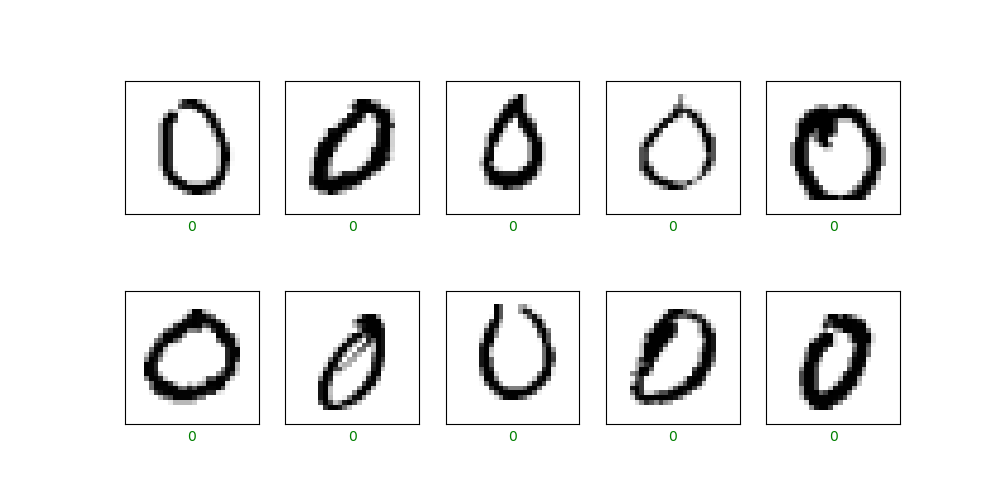

In [ ]:
tfutils.datasets.mnist.plot_ten_random_examples(plt, x ,np.zeros((x.shape[0],1))).show()
#to check the images of our dataset we will plot ten random images using the helper functions

#### Discriminator

![Artist and Critic](artist_critic.png)

In [ ]:
#Discriminator of GAN
discriminator = Sequential([
    Conv2D(64, 3, strides = 2, input_shape = (28,28,1)),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(128, 5, strides = 2),
    LeakyReLU(),
    BatchNormalization(),
    
    Conv2D(256, 5, strides = 2),
    LeakyReLU(),
    BatchNormalization(),
    
    Flatten(),
    Dense(1, activation = 'sigmoid')
    
])
#we are using strides of two so as to skip the pooling layer to reduce the dimension of the data
#we will be using the three convolutional blocks
#last block we will flatten the output
#output layer will contain the dense layer with sigmooid activation since binary classification
#is only requred for classifying whether the image is real or fake

opt = tf.keras.optimizers.Adam(lr = 2e-4, beta_1 = 0.5)

discriminator.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
#compiling the model
discriminator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 13, 13, 64)        640       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 13, 13, 64)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 13, 13, 64)        256       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 5, 5, 128)         204928    
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 5, 5, 128)         0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 5, 5, 128)         512       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 1, 1, 256)        

#### Generator

In [ ]:
#Generator of the GAN, opposite of the above process
generator = Sequential([
    Dense(256, activation = 'relu', input_shape =(1,)),
    Reshape((1,1,256)),
    
    Conv2DTranspose(256, 5, activation ='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(128, 5, activation ='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(64, 5, strides = 2, activation ='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(32, 5, activation ='relu'),
    BatchNormalization(),
    
    Conv2DTranspose(1, 4, activation = 'sigmoid')
])

generator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               512       
_________________________________________________________________
reshape (Reshape)            (None, 1, 1, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 5, 5, 256)         1638656   
_________________________________________________________________
batch_normalization_9 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 9, 9, 128)         819328    
_________________________________________________________________
batch_normalization_10 (Batc (None, 9, 9, 128)         512       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 21, 21, 64)       

<IPython.core.display.Javascript object>


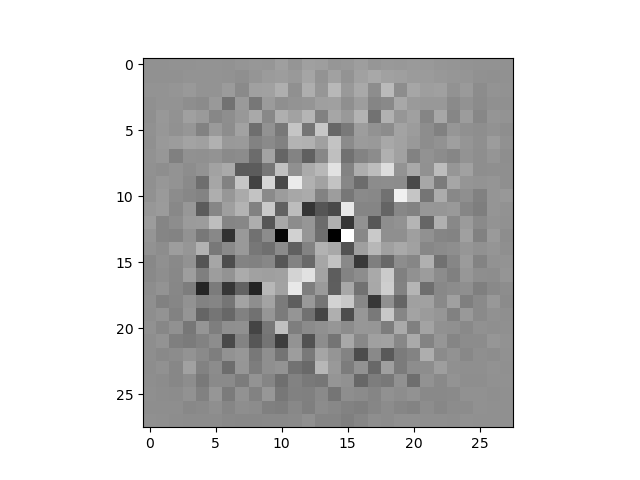

In [ ]:
#random output generator will generate
noise = np.random.randn(1,1)
gen_image = generator.predict(noise)[0]

#plotting the random generated figure
plt.figure()
plt.imshow(np.reshape(gen_image, (28,28)),cmap= 'binary')
plt.show()

In [ ]:
#Creating the Generative  Adversial network with the help of discriminator and generator creating DCGAN
input_layer = tf.keras.layers.Input(shape = (1,))
gen_out = generator(input_layer)
dis_out = discriminator(gen_out)

gan = Model(
    input_layer,
    dis_out
)

discriminator.trainable = False
#we will set the trainable to False by default
#because while the discriminator is trained we don't want the generator to train

#compiling the gan
gan.compile(loss = 'binary_crossentropy', optimizer = opt, metrics = ['accuracy'])
gan.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 28, 28, 1)         2717025   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1027073   
Total params: 3,744,098
Trainable params: 2,716,065
Non-trainable params: 1,028,033
_________________________________________________________________


In [ ]:
#training of the GAN
epochs = 25
batch_size = 128
steps_per_epoch = int(2 * x.shape[0]/batch_size)

print('Steps per epoch=' , steps_per_epoch)

Steps per epoch= 107


<IPython.core.display.Javascript object>


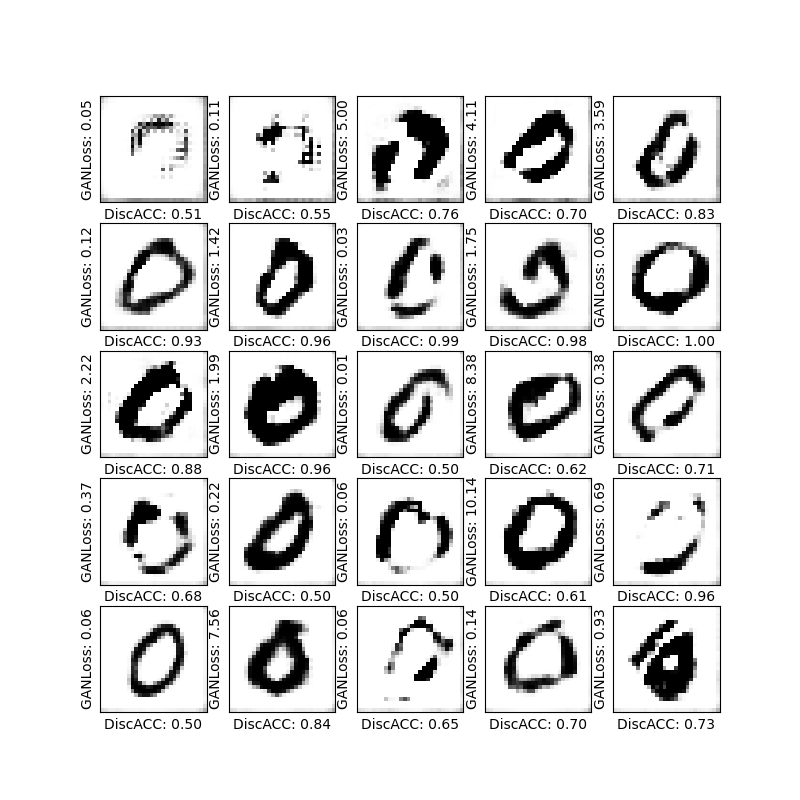

In [ ]:
#will be used to plot the images
dp = tfutils.plotting.DynamicPlot(plt, 5, 5, (8,8))
#generating the dataset which contains original images and random images
for e in range(0,epochs):
    dp.start_of_epoch(e)
    
    for step in range(0,steps_per_epoch):
        true_examples = x[int(batch_size/2)* step:int(batch_size/2)*(step+1)]
        #we will use only half of the batch size for the original images
        true_examples = np.reshape(true_examples, (true_examples.shape[0],28,28,1))
        
        #later half we will use for the generated images
        noise = np.random.randn(int(batch_size/2),1)
        gen_examples = generator.predict(noise)
        
        #generating the x batch with true and generated images
        x_batch = np.concatenate([gen_examples, true_examples], axis =0)
        #labels for the x batch data
        y_batch = np.array([0]*int(batch_size/2) + [1]*int(batch_size/2))
        
        indices = np.random.choice(range(batch_size), batch_size, replace = False)
        #to randomly select the data in the batches
        
        x_batch = x_batch[indices]
        y_batch = y_batch[indices]
        
        #lets set the discriminator to trainable
        discriminator.trainiable = True
        discriminator.train_on_batch(x_batch, y_batch)
        discriminator.trainabel = False
        
        #training of the GAN, basically training only generator only since discriminator trainable is set to false
        loss, _ = gan.train_on_batch(noise, np.ones((int(batch_size/2),1)))
        _, acc = discriminator.evaluate(x_batch, y_batch, verbose = False)
        
    noise = np.random.randn(1,1)
    gen_image = generator.predict(noise)[0]
    gen_image = np.reshape(gen_image, (28,28))
    dp.end_of_epoch(gen_image, 'binary', 'DiscACC: {:.2f}'.format(acc), 'GANLoss: {:.2f}'.format(loss))
    